In [1]:
import os
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import umap
import json
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.cluster import KMeans, AffinityPropagation
from scipy.spatial import distance
import skimage.morphology as morphology

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


load UKB and dHCP

In [2]:
#model_dir = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-07/14-42-29/' #75 dims
model_dir = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-11/14-10-52/' #10 dims
#model_dir = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/13-54-42/' # 10 dims
#model_dir = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/16-56-49/' # 10 dims

save_dir = model_dir + '/analysis/'
df_ukb = pd.read_csv(model_dir+'/ukb_embeddings_no_sampling.csv')
df_dHCP = pd.read_csv(model_dir+'/dHCP_embeddings_no_sampling.csv')

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [3]:
info_dHCP = pd.read_csv('/neurospin/dico/jlaval/data/info_dHCP.csv')
info_dHCP.columns=['sub', 'session_id', 'birth_age', 'scan_age']
df_dhcp = pd.merge(info_dHCP, df_dHCP, on='sub')

# Reconstruction loss

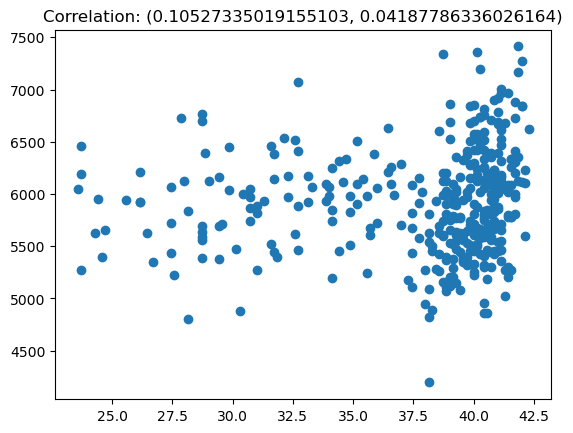

In [4]:
plt.scatter(df_dhcp['birth_age'], df_dhcp['recon'])
P = scipy.stats.pearsonr(df_dhcp['birth_age'], df_dhcp['recon'])
plt.title(f'Correlation: {P}')
plt.show()

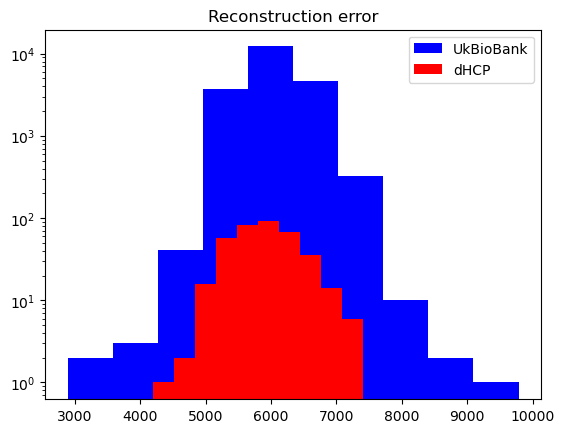

In [5]:
fig,ax=plt.subplots()
ax.hist(df_ukb['recon'], color='blue', label='UkBioBank')
ax.hist(df_dHCP['recon'], color='red', label='dHCP')
plt.yscale('log')
plt.title('Reconstruction error')
plt.legend()
plt.savefig(save_dir+'reconstruction_ukb_dHCP_no_sampling.png', facecolor='white')
plt.show()

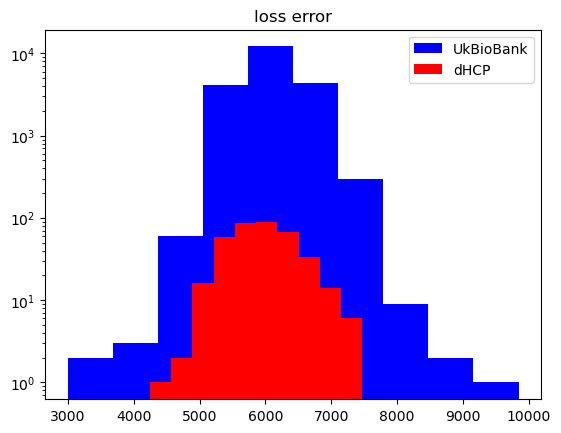

In [6]:
fig,ax=plt.subplots()
ax.hist(df_ukb['loss'], color='blue', label='UkBioBank')
ax.hist(df_dHCP['loss'], color='red', label='dHCP')
plt.yscale('log')
plt.title('loss error')
plt.legend()
plt.show()

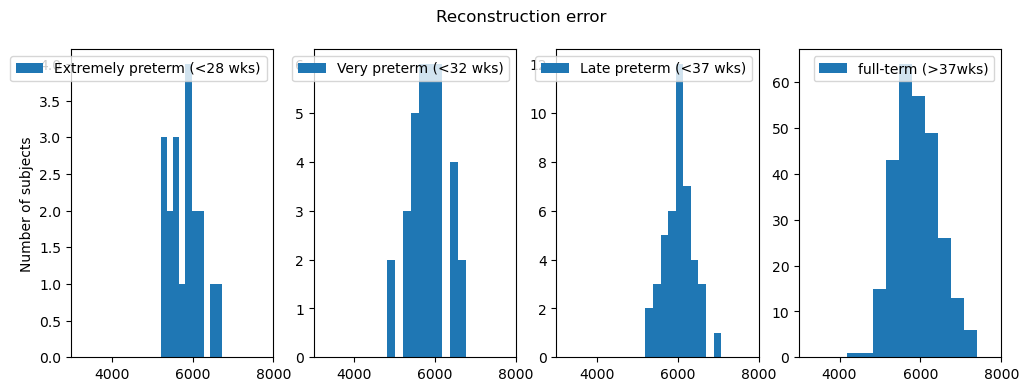

In [8]:
fig,axs=plt.subplots(ncols=4, figsize=(12,4))
#ax.hist(df_ukb['recon'], color='blue', label='UkBioBank')
axs[0].hist(df_dhcp.loc[df_dhcp['birth_age']<28]['recon'], label='Extremely preterm (<28 wks)')
axs[1].hist(df_dhcp.loc[(df_dhcp['birth_age']<32) & (df_dhcp['birth_age']>28)]['recon'], label='Very preterm (<32 wks)')
axs[2].hist(df_dhcp.loc[(df_dhcp['birth_age']<37) & (df_dhcp['birth_age']>32)]['recon'], label='Late preterm (<37 wks)')
axs[3].hist(df_dhcp.loc[df_dhcp['birth_age']>37]['recon'], label='full-term (>37wks)')
axs[0].set_ylabel('Number of subjects')
for i in range(4):
    ax=axs[i]
    ax.set_xlim([3000, 8000])
    ax.legend()
plt.suptitle('Reconstruction error')
plt.savefig(save_dir+'reconstruction_error_dHCP_no_sampling.png', facecolor='white')
plt.show()

NB : use kolomogor-smirnov test to get a p-value on the difference of the distributions.

Maybe the cross entropy loss (sum) is always high because of the thickening of the sulci ? In this case a small interruption is neglectable. Also, our interruptions in preterms are quite small compared to the benchmark experiments. Maybe the algorithm finds things loccaly but it doesn't stand out with image sum.